<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neurons_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# snnTorch - Neuronal Dynamics with ``snntorch``
## Tutorial 2
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will:
* Learn the basics of a leaky integrate-and-fire (LIF)
* Use snnTorch to implement variations of the LIF model: 
  * Lapicque's LIF neuron model
  * Stein's neuron model
  * 0$^{th}$ Order Spike Response Model
<!-- * Plot the output behavior of the neurons -->
<!-- * Interpret the computational graph of a spiking neuron -->
<!-- * Automatically initialize the hidden states of the neurons [keep in tute, but delete explanation]? -->
* Implement a feedforward spiking neural network

>Part of this tutorial was inspired by the book [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [2]:
!pip install snntorch

# 1. The Spectrum of Neuron Models
A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the extremely simple artificial neuron that pervades all facets of modern deep learning.

**Hodgkin-Huxley Neuron Models**$-$While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use. We expect this to change as more rigorous theories of how neurons contribute to higher-order behaviors in the brain are uncovered.

**Artificial Neuron Model**$-$On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights and passed through an activation function. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks.

**Leaky Integrate-and-Fire Neuron Models**$-$Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike. The LIF neuron abstracts away the shape and profile of the output spike; it is simply treated as a discrete event. As a result, information is not stored within the spike, but rather the timing (or frequency) of spikes. Simple spiking neuron models have produced much insight into the neural code, memory, network dynamics, and more recently, deep learning. The LIF neuron sits in the sweet spot between biological plausibility and practicality. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>

<!-- Researchers might spend their entire lives dedicated to developing neuron models. Some of these models are straightforward extensions of the HH and LIF models, while other models find completely different applications, such as in neuropharmocology. -->

The different versions of the LIF model each have their own dynamics and use-cases. snnTorch currently supports three types of LIF neurons:
* Lapicque's RC model: ``snntorch.Lapicque``
* Stein's neuron model: ``snntorch.Stein``
* 0$^{th}$ Order Spike Response Model: ``snntorch.SRM0``

Before learning how to use them, let's understand how to construct a simple LIF neuron model.

<!-- In general, the most obvious difference is that the SRM0 model incorporates a delay between the input and output. When an input spike arrives at an SRM0 neuron, the membrane potential will increase over a finite time. If an output spike were to be triggered, it would experience a delay with respect to the input. On the other hand, Stein's model allows for an instantaneous rise of membrane potential. We'll dig into where these might be useful shortly. -->


# 1. The Leaky Integrate-and-Fire Neuron Model

## 1.1 Spiking Neurons: Intuition

A neuron might be connected to 1,000 $-$ 10,000 other neurons. If one neuron spikes, all of these downhill neurons will feel it. But what determines whether a neuron spikes in the first place? The past century of experiments demonstrate that if a neuron experiences *sufficient* stimulus at its input, then we might expect it to become excited and fire its own spike. 

Where does this stimulus come from? It could be from
* the sensory periphery, 
* an invasive electrode artificially stimulating the neuron, or in most cases,
* from other pre-synaptic neurons. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>


Given that these spikes are very short bursts of electrical activity, it is quite unlikely for all input spikes to arrive at the neuron body in precise unison. This indicates the presence of temporal dynamics that 'sustain' the input spikes, kind of like a delay.


## 1.2 The Passive Membrane

Like all cells, a neuron is surrounded by a thin membrane. This membrane is a lipid bilayer that insulates the conductive saline solution within the neuron from the extracellular medium. Electrically, the two conductors separated by an insulator is a capacitor. 

Another function of this membrane is to control what goes in and out of this cell (e.g., ions such as Na$^+$). The membrane is usually impermeable to ions which blocks them from entering and exiting the neuron body. But there are specific channels in the membrane that are triggered to open by injecting current into the neuron. This charge movement is electrically modelled by a resistor.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>


Now say some arbitrary time-varying current $I_{\rm in}(t)$ is injected into the neuron, be it via electrical stimulation or from other neurons. The total current in the circuit is conserved, so:

$$I_{\rm in}(t) = I_{R} + I_{C}$$

From Ohm's Law, the membrane potential measured between the inside and outside of the neuron $U_{\rm mem}$ is proportional to the current through the resistor:

$$I_{R} = \frac{U_{\rm mem}}{R}$$

The capacitance is a proportionality constant between the charge stored on the capacitor $Q$ and $U_{\rm mem}$:


$$Q = CU_{\rm mem}$$

The rate of change of charge gives the capacitive current:

$$\frac{dQ}{dt}=I_C = C\frac{dU_{\rm mem}}{dt}$$

Therefore:

$$I_{\rm in}(t) = \frac{U_{\rm mem}}{R} + C\frac{dU_{\rm mem}}{dt}$$
$$\implies RC \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t)$$

The right hand side of the equation is **\[Voltage]**. On the left hand side of the equation, the term $\frac{dU_{\rm mem}}{dt}$ is of units **\[Voltage/Time]**. To equate it to a voltage, $RC$ must be of unit **\[Time]**. We refer to $\tau = RC$ as the time constant of the circuit:

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t)$$

The passive membrane is therefore described by a linear differential equation.

For a derivative of a function to be of the same form as the original function, i.e., $\frac{dU_{\rm mem}}{dt} \propto U_{\rm mem}$, this implies the solution is exponential with a time constant $\tau$.

Say the neuron starts at some value $U_{0}$ with no further input, i.e., $I_{\rm in}(t)=0$. The solution of the linear differential equation is:

$$U_{\rm mem} = U_0e^{-\frac{t}{\tau}}$$


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

## 1.3 Lapicque's LIF Neuron Model

This similarity between nerve membranes and RC circuits was observed by [Louis Lapicque in 1907](https://core.ac.uk/download/pdf/21172797.pdf). He stimulated the nerve fiber of a frog with a brief electrical pulse, and found that membranes could be approximated as a capacitor with a leakage. We pay homage to his findings by naming the basic LIF neuron model in snnTorch after him. 

Now it's time to generate this result.

### 1.3.1 Lapicque: Without Stimulus

First, import the packages needed to run Lapicque's neuron model: snnTorch and PyTorch.

In [195]:
import snntorch as snn
import torch

The membrane potential has a time constant $\tau = RC$ associated with it. This can be recast into a decay rate $\beta$ that specifies the ratio of membrane between subsequent time steps:

$$\beta = \frac{e^{-\frac{1}{\tau}}}{e^{-\frac{0}{\tau}}} = \frac{e^{-\frac{2}{\tau}}}{e^{-\frac{1}{\tau}}} = \frac{e^{-\frac{3}{\tau}}}{e^{-\frac{2}{\tau}}}=~~...$$
$$\implies \beta = e^{-\frac{1}{\tau}}$$

Setting $\tau = 5 \implies \beta \approx 0.82$:

In [212]:
# RC time constant
tau_mem = 5e-3
time_step = 1e-3

# decay p/time step
beta = float(torch.exp(torch.tensor(-time_step/tau_mem)))

print(f"Membrane decay rate ('beta'): {beta}")

Membrane decay rate ('beta'): 0.8187307715415955


In [213]:
# Number of time steps to simulate
num_steps = 200

Instantiating Lapicque's neuron only requires the following line of code:

In [214]:
# leaky integrate and fire neuron
lif1 = snn.Lapicque(beta=beta)

To use this neuron: 

**Inputs**
* `spk_in`: each element of $I_{\rm in}$, which are all `0` for now, is sequentially passed as an input
* `mem`: the membrane potential at the present time $t$ is also passed as input. Initialize it arbitrarily as $U_0 = 0.9$.

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t+1]$ at the next time step
* `mem`: membrane potential $U_{\rm mem}[t+1]$ at the next time step

These all need to be of type `torch.Tensor`.


In [215]:
# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # membrane potential of 0.9 at t=0
cur_in = torch.zeros(num_steps)  # input is 0 for all t 
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

These values are only for the initial time step $t=0$. We'd like to watch the evolution of `mem` over time. The list `mem_rec` is initialized to record these values at every time step.

In [216]:
# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

Now it's time to run a simulation! 50 time steps will be simulated, updating `mem` at each step and recording its value in `mem_rec`:

In [217]:
# pass updated value of mem and spk_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

Well that was simple. 

Let's take a look at how the membrane potential and synaptic current evolved.

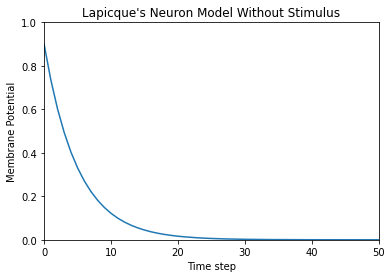

In [218]:
import matplotlib.pyplot as plt

plt.title("Lapicque's Neuron Model Without Stimulus")
plt.plot(mem_rec, label="Membrane Potential")
plt.xlabel("Time step")
plt.ylabel("Membrane Potential")
plt.xlim([0, 50])
plt.ylim([0, 1])
plt.show()

This matches the dynamics that were previously derived. We should have convinced ourselves that the membrane potential will decay over time in the absence of any input stimuli. 

### 1.3.2 Lapicque: Step Input

Now let's apply a step current $I_{\rm in}$ that switches on at $t=t_0$. Based on the linear first-order differential equation:

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t)$$

Then the general solution will be:

$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

If the membrane potential is initialized as $U_{\rm mem} = 0 V$, then:

$$U_{\rm mem}=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

Let's visualize what this looks like by triggering the current pulse at $t_0 = 10$.

In [219]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.05), 0)  # input turns on at t=10

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

As before, 200 time steps will be simulated. But this time, the new values of `cur_in` will be passed:

In [220]:
# pass updated value of mem and spk_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

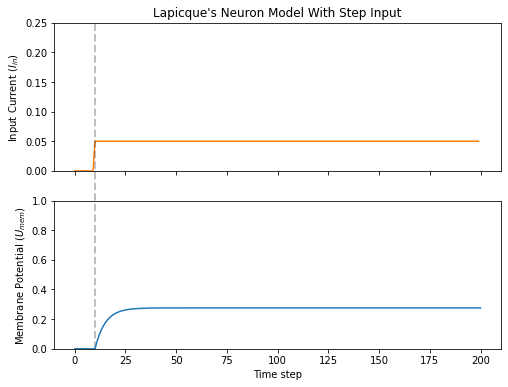

In [221]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.25])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Step Input")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

The membrane potential exponentially rises and then stabilizes.

### 1.3.3 Lapicque: Pulse Input

Now what if the step input was clipped at $t=30$? We would expect it to rise just as it did above, but then decay with a time constant of $\tau$ as in our first simulation. 

In [222]:
# Initialize input current pulse. On at t=10, off at t=30.
cur_in = torch.cat((torch.zeros(10), torch.ones(20)*0.05, torch.zeros(170)), 0)  # input turns on at t=10, off at t=30

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

In [223]:
# pass updated value of mem and spk_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

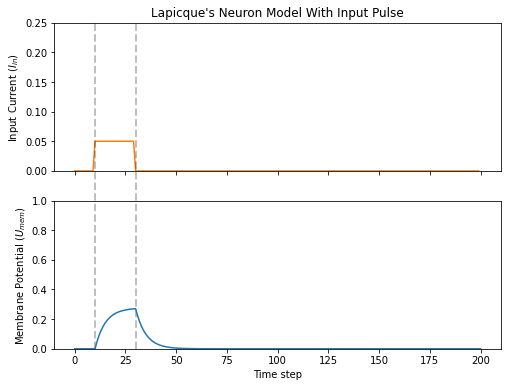

In [224]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.25])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=30, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
plt.xlabel("Time step")

plt.show()

It appears as though our guess was correct. What if the amplitude of the current input was doubled, and the pulse width was halved? That is to say, the area under the current curve remains the same:

$$Q = I \times t,$$

and therefore, the amount of charge delivered to the capacitor is also the same.

In [231]:
# Double amplitude of current pulse; half the time. On at t=10, off at t=30.
cur_in = torch.cat((torch.zeros(10), torch.ones(5)*0.1, torch.zeros(185)), 0)  # input turns on at t=10, off at t=30

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

In [232]:
# pass updated value of mem and spk_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

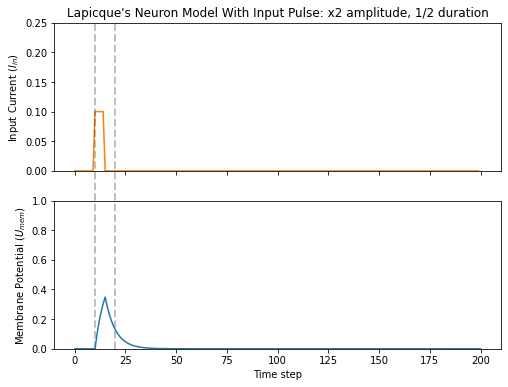

In [233]:
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.25])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse: x2 amplitude, 1/2 duration")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=20, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

plt.xlabel("Time step")

plt.show()

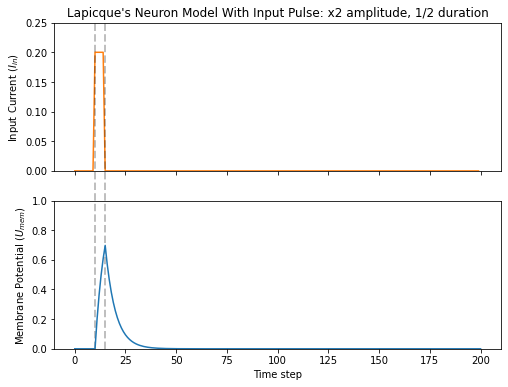

In [187]:
# Double amplitude of current pulse; half the time. On at t=10, off at t=30.
cur_in = torch.cat((torch.zeros(10), torch.ones(5)*0.2, torch.zeros(185)), 0)  # input turns on at t=10, off at t=30

# Initialize membrane and output
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

# Initialize somewhere to store recordings of membrane potential
mem_rec = [mem]

# pass updated value of mem and spk_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

# Generate Plots
fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

# Plot input current
ax[0].plot(cur_in, c="tab:orange")
ax[0].set_ylim([0, 0.25])
ax[0].set_ylabel("Input Current ($I_{in}$)")
ax[0].set_title("Lapicque's Neuron Model With Input Pulse: x2 amplitude, 1/2 duration")

# Plot membrane potential
ax[1].plot(mem_rec)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

ax[1].axvline(x=10, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
ax[1].axvline(x=15, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

plt.xlabel("Time step")

plt.show()

# Conclusion
Now you should understand how to build populations of LIF neuron models to perform feedforward processing of various inputs. 

For reference, the documentation [can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.html).

In the next tutorial, you will learn how to train these networks to classify spiking and static MNIST datasets. In fact, if you already have a basic grasp of PyTorch, the next tutorial will be quite trivial.